In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from collections import defaultdict
from itertools import product
from sklearn.metrics import mean_absolute_error as mae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import StandardScaler

In [2]:
dat = pd.read_csv('train.csv', index_col='row_id')

In [3]:
def preprocess(dat):
    time_mapper = {}
    ii = 0
    for h in range(24):
        for mm in ['00','20','40']:
            hh = '{0:02d}'.format(h)
            time_mapper[hh+':'+mm] = ii
            ii += 1

    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    uniques = dat['unique'].unique()
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    tmp = dat.groupby(['unique','day','time_stamp']).agg({'congestion':np.median})
    median_mapper = tmp.to_dict()['congestion']
    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)
    dat['congestion-median'] = dat['congestion'] - dat['median']
    
    all_time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
    all_time['time'] = all_time['time'].astype(str)
    
    return uniques, median_mapper, time_mapper, all_time

In [4]:
uniques, median_mapper, time_mapper, all_time = preprocess(dat)

In [5]:
def getseries(unique):
    df = dat.loc[dat['unique']==unique, ['time', 'congestion-median']]
    df = pd.merge(all_time, df, left_on='time', right_on='time', how='outer')
    df = df.set_index('time')
    df['congestion-median'] = df['congestion-median'].fillna(0)
    ss = StandardScaler()
    df['congestion-median-normalized'] = ss.fit_transform(df['congestion-median'].values.reshape(-1,1)).reshape(-1)
    return df, ss

In [12]:
data_all = []
for unique in uniques:
    df, ss = getseries(unique)
    data_all.append(df['congestion-median-normalized'].values)
data_all = np.array(data_all)

In [13]:
data_all

array([[ 2.94010361,  2.94010361,  2.94010361, ..., -0.68698284,
         0.52204597,  1.38563798],
       [ 2.0801995 ,  2.0801995 ,  2.0801995 , ..., -0.56857034,
         0.06713442,  0.17308522],
       [-0.06395164, -0.06395164, -0.06395164, ...,  0.40982651,
         1.27841977,  0.17293744],
       ...,
       [ 0.3255764 ,  0.48059593,  0.01553735, ..., -0.13948218,
        -0.13948218, -0.44952124],
       [ 0.64296132,  0.52063081,  0.39830031, ..., -0.45801324,
         0.03130879, -0.58034374],
       [-0.77808444,  2.15393018,  0.54605119, ..., -0.96724668,
         0.73521343, -1.25099003]])

In [14]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA()
data_all_pca = pca.fit_transform(data_all.T)

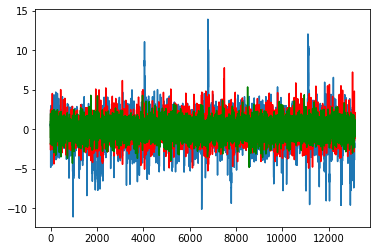

In [24]:
plt.plot(data_all_pca[:,0])
plt.plot(data_all_pca[:,1],'r')
plt.plot(data_all_pca[:,64],'g')

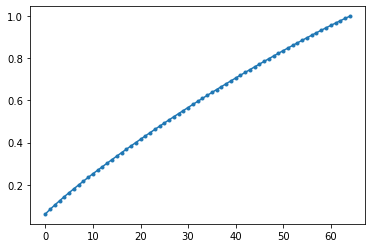

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-')

In [31]:
pca.singular_values_

array([229.09968534, 137.34910827, 133.29683291, 130.18102389,
       129.84870546, 126.34747862, 125.55012743, 124.75671266,
       123.64007552, 123.10389789, 121.89518707, 119.99159695,
       119.97177692, 119.4790721 , 119.14577254, 118.28412088,
       117.95922631, 117.54543347, 117.10257592, 116.62446661,
       115.89521726, 115.65018586, 114.8963526 , 114.89256623,
       114.29995501, 113.90423674, 113.21466925, 112.51125911,
       112.21291797, 111.72513022, 111.42296265, 111.29985351,
       110.62522891, 110.35331388, 109.9025544 , 109.43667203,
       109.03335993, 108.54113261, 108.28646908, 107.98551204,
       107.35935432, 106.81725089, 106.72112483, 106.37972817,
       106.01903616, 105.57760537, 105.21315415, 105.10136313,
       104.7509574 , 104.21078377, 103.57747017, 103.04809321,
       102.69263012, 102.45032538, 101.93186688, 101.35558006,
       100.90370457, 100.61912355, 100.03632944,  99.07768989,
        98.29412921,  97.6984514 ,  97.44219015,  97.10

In [35]:
import copy

In [36]:
pca1 = copy.deepcopy(pca)

In [37]:
pca1.singular_values_[1:] = 0.0

In [39]:
data_all_pca_inversed = pca1.inverse_transform(data_all_pca)

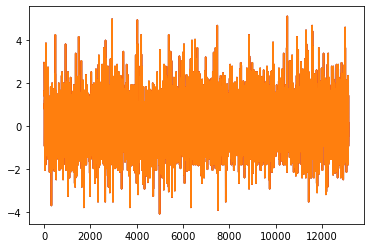

In [43]:
plt.plot(data_all_pca_inversed[:,0])
plt.plot(data_all.T[:,0],'r')
plt.plot(data_all_pca_inversed[:,0])

In [45]:
data_all_pca.shape

(13140, 65)

In [60]:
data_all = data_all.T

In [64]:
data_all_pca = pca.fit_transform(data_all)
data_all_pca[:,1:] = 0.0
data_all_pca_inversed = pca.inverse_transform(data_all_pca)

In [65]:
data_all_pca

array([[0.45036474, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.73587087, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.43689814, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.89473286, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.33331841, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.86773921, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

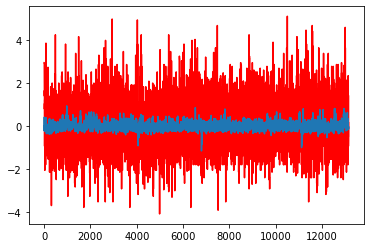

In [68]:
plt.plot(data_all[:,0],'r')
plt.plot(data_all_pca_inversed[:,0])

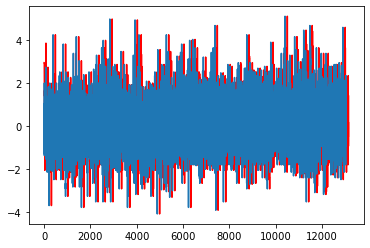

In [71]:
data_all_pca = pca.fit_transform(data_all)
data_all_pca_inversed = pca.inverse_transform(data_all_pca[100:,:])
plt.plot(data_all[:,0],'r')
plt.plot(data_all_pca_inversed[:,0])